# EE5175 Lab 5 : Space Variant Blurring
Author: Kishore Rajendran [EE20B064]

Date: 11 March 2024

In [1]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#### Generating the standard deviation map

Space variant blurring means the value of standard deviation can change from pixel to pixel.

We've been given the standard deviation values at every pixel, by the distribution:

$$\sigma(m, n) = A exp(\frac{-((m - N/2)^{2}+(n - N/2)^{2})}{B}), 0\leq m,n \leq N-1 $$


Now, since $\sigma(N/2, N/2)$ = 2 and $\sigma(0, 0)$ = 0.01, we can substitute these values in the above equation and solve for A and B.

We get A = 2, B = $\frac{N^{2}}{2ln(200)}$
ie. The distribution is:

$$\sigma(m, n) = 2 exp(\frac{-((m - N/2)^{2}+(n - N/2)^{2})}{\frac{N^{2}}{2ln(200)}}), 0\leq m,n \leq N-1 $$


In [2]:
def sig_dist_values(m, n, N):
    return 2*np.exp(-(np.square(m - (N/2)) + np.square(n - (N/2)))/(((N**2)/(2*np.log(200)))))

def generate_sigma_map(N):
    x = y = np.arange(N)
    xx, yy = np.meshgrid(x, y)
    sigma_map = sig_dist_values(xx, yy, N)
    return sigma_map

#### Code for Space invariant blurring and generating the Gaussian blur kernel from previous assignment

Constructing a Gaussian Blur kernel with given standard deviation

In [3]:
# A function to generate the values from a 2D gaussian distribution
def gaussian_2d_values(m, n, stdev):
    return (1/(2*np.pi*stdev**2))*np.exp(-(np.square(m) + np.square(n))/(2*stdev**2))

# A function to construct the gaussian blur kernel
def gaussian_blur_kernel(stdev):
    kernel_size = np.ceil(6*stdev+1)
    # Make the kernel size odd valued
    if kernel_size%2 == 0: kernel_size+=1
    # Generating meshgrid s.t center is (0,0)
    offset = (kernel_size - 1)/2
    x = y = np.arange(kernel_size) - offset
    xx, yy = np.meshgrid(x, y)
    # Generate the kernel according to the gaussian distribution values
    kernel = gaussian_2d_values(xx, yy, stdev)
    # Normalizing so that the all values of the kernel sum up to one
    kernel /= np.sum(kernel)
    return kernel

Function to convolve an image and kernel to give an output image of the same size as the input image (By choosing pad_size accordingly)

In [4]:
# Define 2D convolution operation
def convolve2d(img, kernel):
    # Flipping the kernel
    flipped_kernel = np.flip(kernel)
    # Pad the image
    kernel_size = kernel.shape[0]
    pad_size = int((kernel_size - 1)/2)
    pad_img = np.pad(img, ((pad_size,pad_size), (pad_size,pad_size)), mode='constant', constant_values=(0,0))
    # Convolving the padded image and the kernel
    conv_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = pad_img[i:i+kernel_size, j:j+kernel_size]
            conv_img[i, j] = np.sum(window*flipped_kernel)
    return conv_img

Using the above defined functions to apply the space invariant gaussian blur on an image

In [5]:
def apply_gaussian_blur(img, stdev):
    # Handling the special case of stdev = 0
    if stdev == 0:
        return img
    # Generating the Gaussian blur kernel
    kernel = gaussian_blur_kernel(stdev)
    # Convolving the image with the blur kernel
    blur_img = convolve2d(img, kernel)
    return blur_img

#### Space Variant Blurring

From the sigma map distribution formula we can see that kernel size for the standard deviation values ($6\sigma+1$) reaches a maximum value of 5 in the bottom row assuming that the image shape (N) is large enough. For the constant sigma case given in Q2, the max kernel size is 7, thus a padding of size 3 is enough in both the cases given to us. 

The pad_size can be adjusted according to the maximum value of $\sigma$.

In [6]:
def apply_sv_blur(img, sigma_map):
    # Pad the image
    pad_size = 3
    pad_img = np.pad(img, ((pad_size,pad_size), (pad_size,pad_size)), mode='constant', constant_values=(0,0))
    # Initialize blurred image
    blur_img = np.zeros_like(pad_img, dtype=np.float64)
    for i in range(pad_size, img.shape[0]+pad_size):
        for j in range(pad_size, img.shape[1]+pad_size):
            # Pick sigma value from yhe given sigma map
            stdev = sigma_map[i-pad_size, j-pad_size]
            # Generating the Gaussian blur kernel
            kernel = gaussian_blur_kernel(stdev)
            kernel_size = np.shape(kernel)[0]
            offset = int((kernel_size - 1)/2)
            blur_img[i-offset:i+offset+1, j-offset:j+offset+1] += kernel*pad_img[i, j]
    # Remove the padding from the resulting image
    blur_img = blur_img[pad_size:-pad_size, pad_size:-pad_size]
    return blur_img

#### Part 1: Space variant blurring on the Globe image

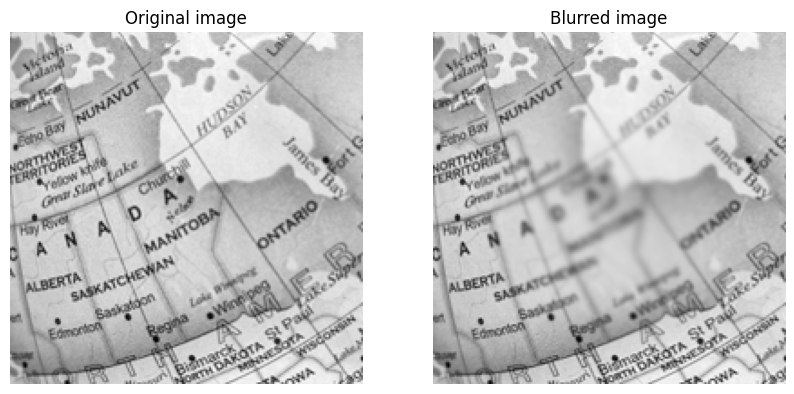

In [7]:
# Importing the image as numpy array
img1 = np.array(Image.open("Globe.png"))

# Generating the standard deviation distribution
sigma_map = generate_sigma_map(img1.shape[0])
# Gaussian blurring the image with given space variant standard deivation distribution
blur_img1 = apply_sv_blur(img1, sigma_map) 

# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')

ax[1].imshow(blur_img1, cmap='gray')
ax[1].set_title("Blurred image")
ax[1].axis('off')

plt.show()

#### Part 2: Blurring the Nautilus image

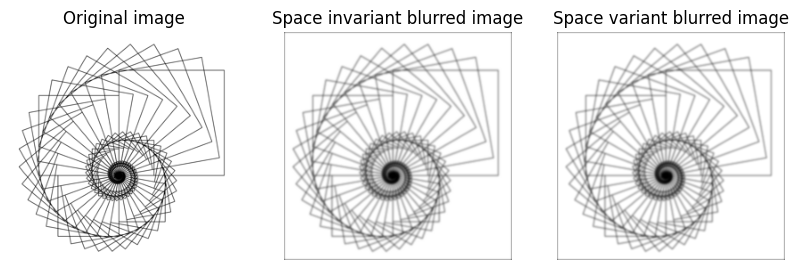

In [8]:
# Importing the image as numpy array
img2 = np.array(Image.open("Nautilus.png"))

# Part (a): Space invariant blur with sigma = 1
blur_img2 = apply_gaussian_blur(img2, 1)

# Part (b): Space variant blur with sigma map = 1 (constant)
sigma_map_const = np.ones_like(img2)
blur_img3 = apply_sv_blur(img2, sigma_map_const)

# Plotting the images side by side
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img2, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')

ax[1].imshow(blur_img2, cmap='gray')
ax[1].set_title("Space invariant blurred image")
ax[1].axis('off')

ax[2].imshow(blur_img3, cmap='gray')
ax[2].set_title("Space variant blurred image")
ax[2].axis('off')

plt.show()

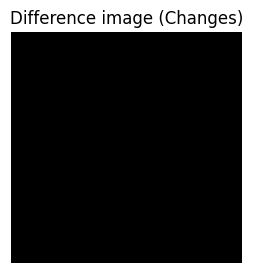

In [19]:
# Detecting Changes
def detect_changes(img1, img2, thresh):
    diff_img = np.abs(img1 - img2)
    # Setting points below chosen threshold to 255 in the diff image
    diff_img[diff_img < thresh] = 255
    return diff_img

changes = detect_changes(blur_img2, blur_img3, thresh=1)
plt.figure(figsize=(3, 3))
plt.imshow(changes, cmap='gray')
plt.title("Difference image (Changes)")
plt.axis('off')
plt.show()

# Observations
1. The given standard deviation distribution $\sigma(m, n)$ looks similar to a gaussian distribution centered around (N/2, N/2), ie. the center of the image. Thus the standard deviation value and in turn the kernel size and hence the blurring is much higher in the center of the image.
2. This is very clearly observed in the blurred globe image, where the center part is quite blurred whereas the borders seem almost unaffected.
3. The detect_changes function shows that the 2 blurred images obtained by space invariant blurring and space variant blurring code with a constant sigma map of same variance (=1) are the same. This is expected since, space variant blur with equal standard deviation at all pixels is the same as space invariant blur with that standard deviation.